In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sktime.datasets import load_basic_motions
from sktime.datasets import load_arrow_head

from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.classification.dictionary_based import BOSSEnsemble
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.compose import ComposableTimeSeriesForestClassifier

from sktime.transformations.panel.compose import ColumnConcatenator

from sktime.utils.slope_and_trend import _slope

In [2]:
X, y = load_arrow_head(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(158, 1) (158,) (53, 1) (53,)


In [3]:
type(X), type(y)

(pandas.core.frame.DataFrame, numpy.ndarray)

In [4]:
X.head()

,dim_0
0,0 -1.963009 1 -1.957825 2 -1.95614...
1,0 -1.774571 1 -1.774036 2 -1.77658...
2,0 -1.866021 1 -1.841991 2 -1.83502...
3,0 -2.073758 1 -2.073301 2 -2.04460...
4,0 -1.746255 1 -1.741263 2 -1.72274...


In [5]:
print(X.iloc[0][0])

0     -1.963009
1     -1.957825
2     -1.956145
3     -1.938289
4     -1.896657
         ...   
246   -1.841345
247   -1.884289
248   -1.905393
249   -1.923905
250   -1.909153
Length: 251, dtype: float64


In [6]:
y

array(['0', '1', '2', '0', '1', '2', '0', '1', '2', '0', '1', '2', '0',
       '1', '2', '0', '1', '2', '0', '1', '2', '0', '1', '2', '0', '1',
       '2', '0', '1', '2', '0', '1', '2', '0', '1', '2', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2',
       '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2

In [7]:
# binary target variable
labels, counts = np.unique(y_train, return_counts=True)
print(labels, counts)

['0' '1' '2'] [60 54 44]


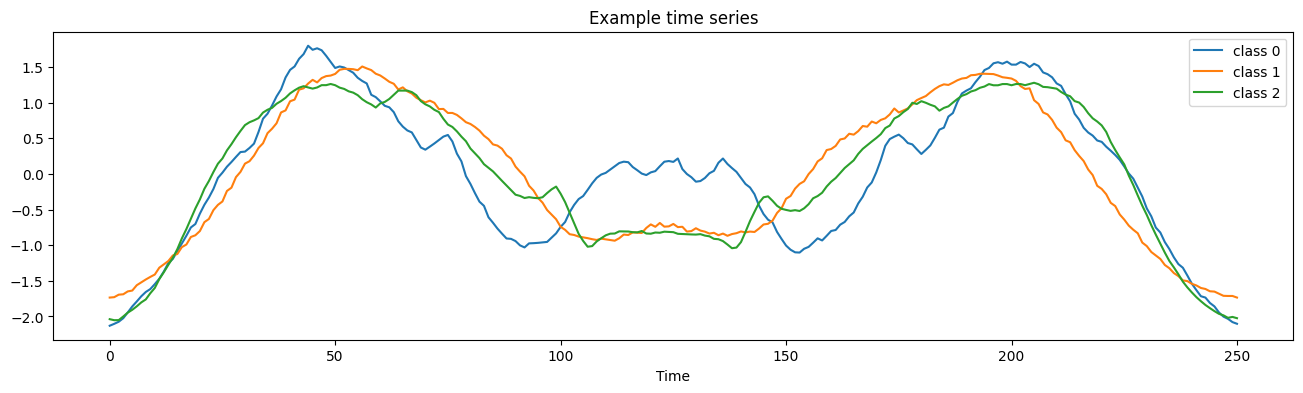

In [8]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
for label in labels:
    X_train.loc[y_train == label, "dim_0"].iloc[0].plot(ax=ax, label=f"class {label}")
plt.legend()
ax.set(title="Example time series", xlabel="Time");

In [9]:
from sklearn.ensemble import RandomForestClassifier

from sktime.datatypes._panel._convert import from_nested_to_2d_array

X_train_tab = from_nested_to_2d_array(X_train)
X_test_tab = from_nested_to_2d_array(X_test)

X_train_tab.head()

,dim_0__0,dim_0__1,dim_0__2,dim_0__3,dim_0__4,dim_0__5,dim_0__6,dim_0__7,dim_0__8,dim_0__9,...,dim_0__241,dim_0__242,dim_0__243,dim_0__244,dim_0__245,dim_0__246,dim_0__247,dim_0__248,dim_0__249,dim_0__250
33,-2.130812,-2.104430,-2.074755,-2.025406,-1.944910,-1.860405,-1.790645,-1.717512,-1.657323,-1.616462,...,-1.631596,-1.716735,-1.735734,-1.811056,-1.859587,-1.944460,-2.003032,-2.034098,-2.080031,-2.103448
68,-1.895550,-1.896260,-1.880250,-1.896491,-1.875607,-1.833061,-1.829426,-1.800726,-1.767301,-1.739180,...,-1.422673,-1.480816,-1.535985,-1.585074,-1.627124,-1.655245,-1.708382,-1.775232,-1.836068,-1.873608
193,-2.038970,-2.053289,-2.052085,-2.001301,-1.947290,-1.907211,-1.858616,-1.803497,-1.761757,-1.675215,...,-1.729849,-1.786768,-1.839490,-1.884153,-1.925921,-1.963895,-1.985153,-2.019928,-2.007297,-2.025093
35,-1.801050,-1.798915,-1.778375,-1.759428,-1.701133,-1.671777,-1.620782,-1.564560,-1.534801,-1.470892,...,-1.487580,-1.551490,-1.592632,-1.620071,-1.688095,-1.717157,-1.759057,-1.796549,-1.798544,-1.801050
155,-1.735623,-1.730093,-1.694933,-1.689494,-1.649237,-1.637335,-1.562168,-1.522661,-1.481994,-1.445810,...,-1.565695,-1.600992,-1.614987,-1.647348,-1.651626,-1.682189,-1.711068,-1.713207,-1.713116,-1.735601


In [10]:
# now we can apply any scikit-learn classifier
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X_train_tab, y_train)
y_pred = classifier.predict(X_test_tab)
accuracy_score(y_test, y_pred)

0.8867924528301887

In [11]:
from sklearn.pipeline import make_pipeline

# with sktime, we can write this as a pipeline
from sktime.transformations.panel.reduce import Tabularizer

classifier = make_pipeline(Tabularizer(), RandomForestClassifier())
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

0.8490566037735849

In [12]:
classifier

Pipeline(steps=[('tabularizer', Tabularizer()),
                ('randomforestclassifier', RandomForestClassifier())])

In [13]:
type(classifier)

sklearn.pipeline.Pipeline

In [14]:
type(Tabularizer())

sktime.transformations.panel.reduce.Tabularizer

In [15]:
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor

transformer = TSFreshFeatureExtractor(default_fc_parameters="minimal")
extracted_features = transformer.fit_transform(X_train)
extracted_features.head()

Feature Extraction: 100%|██████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 1591.32it/s]


,dim_0__sum_values,dim_0__median,dim_0__mean,dim_0__length,dim_0__standard_deviation,dim_0__variance,dim_0__root_mean_square,dim_0__maximum,dim_0__absolute_maximum,dim_0__minimum
0,-4.378000e-07,0.042834,-1.744223e-09,251.0,0.998006,0.996016,0.998006,1.799248,2.130812,-2.130812
1,-5.018000e-08,-0.010786,-1.999203e-10,251.0,0.998006,0.996016,0.998006,1.636446,1.896491,-1.896491
2,-5.820000e-07,0.026784,-2.318725e-09,251.0,0.998006,0.996016,0.998006,1.279236,2.053289,-2.053289
3,5.364000e-07,0.138155,2.137052e-09,251.0,0.998006,0.996016,0.998006,1.352713,1.801050,-1.801050
4,1.470000e-07,-0.002138,5.856574e-10,251.0,0.998006,0.996016,0.998006,1.507846,1.735623,-1.735623


In [17]:
extracted_features.shape

(158, 10)

In [16]:
classifier = make_pipeline(
    TSFreshFeatureExtractor(show_warnings=False), RandomForestClassifier()
)
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 53/53 [00:03<00:00, 14.18it/s]


0.8301886792452831

In [30]:
time_series_tree

Pipeline(steps=[('extract',
                 RandomIntervalFeatureExtractor(features=[<function mean at 0x00000224E99F0DC0>,
                                                          <function std at 0x00000224E99F0F70>,
                                                          <function _slope at 0x00000224FD4174C0>])),
                ('clf', DecisionTreeClassifier())])

In [41]:
from sktime.classification.interval_based import TimeSeriesForestClassifier
tsf = TimeSeriesForestClassifier()
tsf.fit(X_train, y_train)
tsf.score(X_test, y_test)

0.8113207547169812

In [42]:
tsf

TimeSeriesForestClassifier()

# Multivariate

In [43]:
X, y = load_basic_motions(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60, 6) (60,) (20, 6) (20,)


In [44]:
#  multivariate input data
X_train.head()

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5
9,0 -0.407421 1 -0.407421 2 2.355158 3...,0 1.413374 1 1.413374 2 -3.928032 3...,0 0.092782 1 0.092782 2 -0.211622 3...,0 -0.066584 1 -0.066584 2 -3.630177 3...,0 0.223723 1 0.223723 2 -0.026634 3...,0 0.135832 1 0.135832 2 -1.946925 3...
64,0 0.383922 1 0.383922 2 -0.272575 3...,0 0.302612 1 0.302612 2 -1.381236 3...,0 -0.398075 1 -0.398075 2 -0.681258 3...,0 0.071911 1 0.071911 2 -0.761725 3...,0 0.175783 1 0.175783 2 -0.114525 3...,0 -0.087891 1 -0.087891 2 -0.503377 3...
5,0 -0.357300 1 -0.357300 2 -0.005055 3...,0 -0.584885 1 -0.584885 2 0.295037 3...,0 -0.792751 1 -0.792751 2 0.213664 3...,0 0.074574 1 0.074574 2 -0.157139 3...,0 0.159802 1 0.159802 2 -0.306288 3...,0 0.023970 1 0.023970 2 1.230478 3...
47,0 -0.352746 1 -0.352746 2 -1.354561 3...,0 0.316845 1 0.316845 2 0.490525 3...,0 -0.473779 1 -0.473779 2 1.454261 3...,0 -0.327595 1 -0.327595 2 -0.269001 3...,0 0.106535 1 0.106535 2 0.021307 3...,0 0.197090 1 0.197090 2 0.460763 3...
34,0 0.052231 1 0.052231 2 -0.54804...,0 -0.730486 1 -0.730486 2 0.70700...,0 -0.518104 1 -0.518104 2 -1.179430 3...,0 -0.159802 1 -0.159802 2 -0.239704 3...,0 -0.045277 1 -0.045277 2 0.023970 3...,0 -0.029297 1 -0.029297 2 0.29829...


In [45]:
# multi-class target variable
np.unique(y_train)

array(['badminton', 'running', 'standing', 'walking'], dtype='<U9')

In [49]:
steps = [
    ("concatenate", ColumnConcatenator()),
    ("classify", TimeSeriesForestClassifier(n_estimators=100)),
]
clf = Pipeline(steps)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.2

In [50]:
clf.predict(X_test)

array(['walking', 'running', 'running', 'running', 'badminton', 'walking',
       'running', 'walking', 'running', 'running', 'walking', 'standing',
       'walking', 'standing', 'running', 'walking', 'walking', 'running',
       'walking', 'badminton'], dtype='<U9')

In [52]:
y_test

array(['badminton', 'standing', 'walking', 'badminton', 'running',
       'walking', 'running', 'badminton', 'standing', 'running',
       'standing', 'badminton', 'walking', 'badminton', 'walking',
       'standing', 'badminton', 'walking', 'running', 'standing'],
      dtype='<U9')

In [53]:
clf = ColumnEnsembleClassifier(
    estimators=[
        ("TSF0", TimeSeriesForestClassifier(n_estimators=100), [0]),
        ("BOSSEnsemble3", BOSSEnsemble(max_ensemble_size=5), [3]),
    ]
)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9

In [54]:
clf.predict(X_test)

array(['badminton', 'standing', 'walking', 'badminton', 'running',
       'walking', 'running', 'running', 'standing', 'running', 'standing',
       'badminton', 'walking', 'badminton', 'walking', 'running',
       'badminton', 'walking', 'running', 'standing'], dtype='<U9')

In [55]:
y_test

array(['badminton', 'standing', 'walking', 'badminton', 'running',
       'walking', 'running', 'badminton', 'standing', 'running',
       'standing', 'badminton', 'walking', 'badminton', 'walking',
       'standing', 'badminton', 'walking', 'running', 'standing'],
      dtype='<U9')